In [1]:
from fastbook import *
from fastai.vision.all import * 
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [2]:
import timm

In [3]:
data_path = Path('data')/'01'
data_path.mkdir(parents=True,exist_ok=True)
searches = "rugby","afl","nfl","soccer"
dataset_path = data_path/"datasets"
failed = verify_images(get_image_files(dataset_path))
failed.map(Path.unlink)

(#0) []

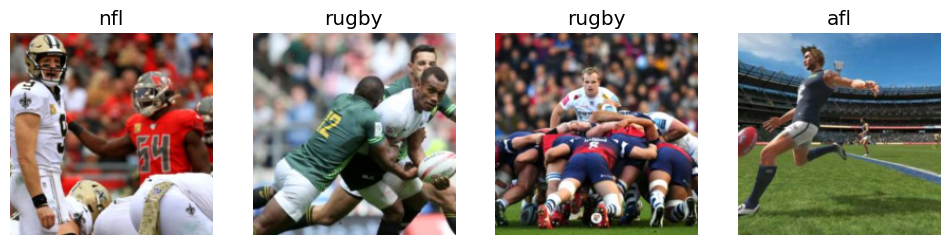

In [4]:
football = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(192)
)

dls = football.dataloaders(dataset_path)
dls.valid.show_batch(max_n=4, nrows=1)

In [5]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.665672,1.715186,0.482759,00:00
1,1.375729,1.246522,0.310345,00:00
2,1.114822,1.031830,0.241379,00:00


In [6]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [7]:
learn = vision_learner(dls, 'convnext_large_in22k', metrics=error_rate).to_fp16()
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.279180,0.245450,0.086207,00:01
1,0.223973,0.059385,0.017241,00:01
2,0.194442,0.052271,0.017241,00:01
3,0.147951,0.021714,0.000000,00:01
4,0.117540,0.012159,0.000000,00:01
5,0.099345,0.013814,0.000000,00:01
6,0.083332,0.013395,0.000000,00:01
7,0.071386,0.015430,0.017241,00:01


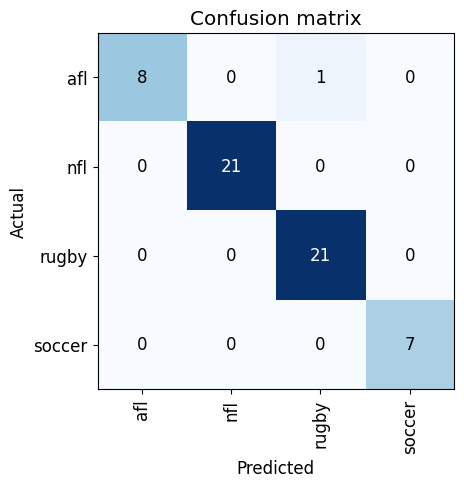

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [9]:
m = learn.model
m

Sequential(
  (0): TimmBody(
    (model): ConvNeXt(
      (stem): Sequential(
        (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
      )
      (stages): Sequential(
        (0): ConvNeXtStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): ConvNeXtBlock(
              (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
              (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
              (mlp): Mlp(
                (fc1): Linear(in_features=192, out_features=768, bias=True)
                (act): GELU()
                (drop1): Dropout(p=0.0, inplace=False)
                (norm): Identity()
                (fc2): Linear(in_features=768, out_features=192, bias=True)
                (drop2): Dropout(p=0.0, inplace=False)
              )
              (shortcut): Identity()
              (drop_path): Identity()
  

In [10]:
l = m.get_submodule('0.model.stem.1')
l

LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)

In [11]:
np.set_printoptions(precision=3, suppress=True)
for param in l.parameters():
    numpy_param = param.detach().cpu().numpy()
    print(numpy_param)

[ 1.09   1.404 -0.014 -0.009  1.557 -0.021  1.975  5.523  0.408  2.475  1.747  2.581  0.676  2.099  0.858  0.903  1.834 -0.014 -0.002  2.529  1.608  0.771  0.3    0.669  1.385  4.506 -0.102  0.022
  5.126 -0.09   0.723  0.631  1.135  1.198  3.029  2.302  1.502  5.59   3.958  0.511  4.117  1.122  1.888  0.566  0.017  1.078  0.006 -0.013  1.198  1.379  1.118 -0.025  2.169  0.475  3.627  0.008
  0.099  2.727  0.358  1.164  4.119  0.763  1.454  2.043  0.467  1.493  4.276  0.001  0.011 -0.035 -0.36   0.376  0.937 -0.025 -0.019  3.812  0.036  4.697  2.183  1.329  1.122  0.258  0.704  3.722
  1.892 -0.021  3.83   0.866  4.975  0.982  1.363  1.677  0.66   4.676  0.757  0.636  0.34   4.895 -0.004  1.639  0.898 -0.002  2.843  4.003 -0.42   0.836  1.235  4.736  1.162 -0.013  0.017  1.189
 -0.01   1.809  0.832  0.004  1.468 -0.026  1.582  0.031  1.272 -0.006 -0.01   0.822  0.812  1.583  2.06   0.007  0.591  0.002  1.391 -0.006  1.165  5.526  2.865 -0.001 -0.541  3.624  5.272  1.894
  0.779  1.645 

## Define a quadratic

In [12]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

In [13]:
def quad(a, b, c, x): return a*x**2 + b*x + c

In [14]:
quad(3,2,1,1.5)

10.75

## Partials
Allow defining a new function with fixed constants for a, b, c

In [46]:
from functools import partial
def mk_quad(a, b, c): 
    return partial(quad,a,b,c)

In [45]:
f = mk_quad(3,2,1)
f(1.5)

10.75

Use our partial to make it so we can easily change to constants and see how it plots

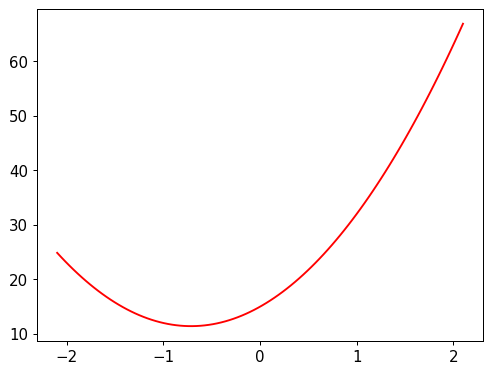

In [17]:
plot_function(mk_quad(7, 10, 15))

In [18]:
from numpy.random import normal,seed,uniform
np.random.seed(42)
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

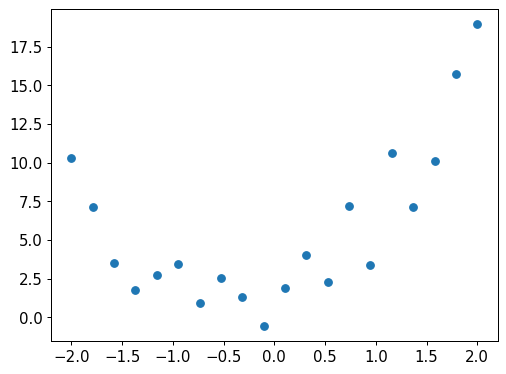

In [39]:
# 20 points between -2 and 2 with shape (20, 1)
x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.3, 1.5)
plt.scatter(x,y);

Now we can fit by hand:

In [20]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

## Loss Function
Mean Squared Error loss function

In [21]:
def mse(preds, acts): 
    return ((preds-acts)**2).mean()

In [22]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    f = mk_quad(a, b, c)
    plt.scatter(x,y)
    loss = mse(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [42]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x), y)

In [47]:
quad_mse([1.5, 1.5, 1.5])

tensor(11.4648, dtype=torch.float64)

Create a new tensor, but add a gradient so we can tell if our results are getting better or worse 

In [53]:
abc = torch.tensor([1.5,1.5,1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

Calculate the the mean squared loss

In [49]:
loss = quad_mse(abc)
loss

tensor(11.4648, dtype=torch.float64, grad_fn=<MeanBackward0>)

Predictions

In [102]:
f(x)

tensor([[ 9.0000],
        [ 7.0277],
        [ 5.3213],
        [ 3.8809],
        [ 2.7064],
        [ 1.7978],
        [ 1.1551],
        [ 0.7784],
        [ 0.6676],
        [ 0.8227],
        [ 1.2438],
        [ 1.9307],
        [ 2.8837],
        [ 4.1025],
        [ 5.5873],
        [ 7.3379],
        [ 9.3546],
        [11.6371],
        [14.1856],
        [17.0000]])

Actuals

In [103]:
y

tensor([[10.2751],
        [ 7.1105],
        [ 3.4772],
        [ 1.7360],
        [ 2.7247],
        [ 3.4439],
        [ 0.8875],
        [ 2.5305],
        [ 1.2789],
        [-0.5801],
        [ 1.9068],
        [ 4.0148],
        [ 2.2443],
        [ 7.2023],
        [ 3.3858],
        [10.6209],
        [ 7.1300],
        [10.1091],
        [15.7330],
        [18.9939]], dtype=torch.float64)

Do a backward pass

In [50]:
loss.backward()

In [51]:
abc.grad

tensor([-10.9887,  -2.1225,  -4.0015])

Update the values slightly, 

In [52]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mse(abc)

print(f'loss={loss:.2f}')

loss=10.11


In [141]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=12.11
step=1; loss=10.02
step=2; loss=7.28
step=3; loss=4.90
step=4; loss=3.76


In [84]:
abc

tensor([3.2729, 2.5155, 0.7215], requires_grad=True)

In [104]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.0)

In [125]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), ylim=(-1,4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [126]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

In [127]:
@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…